# watershed-f50-sand.ipynb

This notebook extends the basic watershed segmentation performed in notebook 00 to three dimensions. 
Steps performed here include:
- Load data
- Binarize images
- Perform 3D watershed segmentation
- Save segmented images

Note: `napari` is recommended as an image viewer since it opens the image in a separate window and allows subsequently loaded images to be seen as layers above other images. However, if you are having trouble installing `napari` (there are known issues with the dependency `VisPy` on some new MacBooks), or if you would rather not use `napari` for some other reason, a cell is included that shows how to view images using `matplotlib.pyplot` instead. This can be extrapolated to all cells utilizing `napari`.

# Import packages

In [1]:
use_napari = True
# Standard library imports
from pathlib import Path
import sys
# Third-party imports
import matplotlib.pyplot as plt
if use_napari:
    import napari
import numpy as np
from scipy import ndimage as ndi
import skimage
# Local imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
import watershed
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

## Load, binarize, and segment 3D data

Define path to images and load as 3D array. If path contains backslasshes, use raw string by placing an `r` before the first quote of the string.

In [2]:
# ----------------------- #
# PATH TO F50 SAND IMAGES #
# ----------------------- #
img_path = Path(r'C:\Users\gusb\Research\mhe-analysis\data\F50_1_scan1')

# Load images as 3D array from a directory containing images
imgs = watershed.load_images(
    img_path, 
    return_3d_array=True,
    convert_to_float=False
)
print(f'Images loaded as 3D array: {imgs.shape}')

Images loaded as 3D array: (631, 1920, 1920)


In [3]:
if use_napari:
    # Open napari viewer
    viewer = napari.Viewer()
    # Add raw images to napari window
    viewer.add_image(imgs, name='raw')
else:
    # Set index to preview single image with matplotlib
    preview_index = 400
    fig, ax = plt.subplots(dpi=300)
    ax.imshow(imgs[preview_index, :, :])
    ax.set_axis_off()
    plt.show()

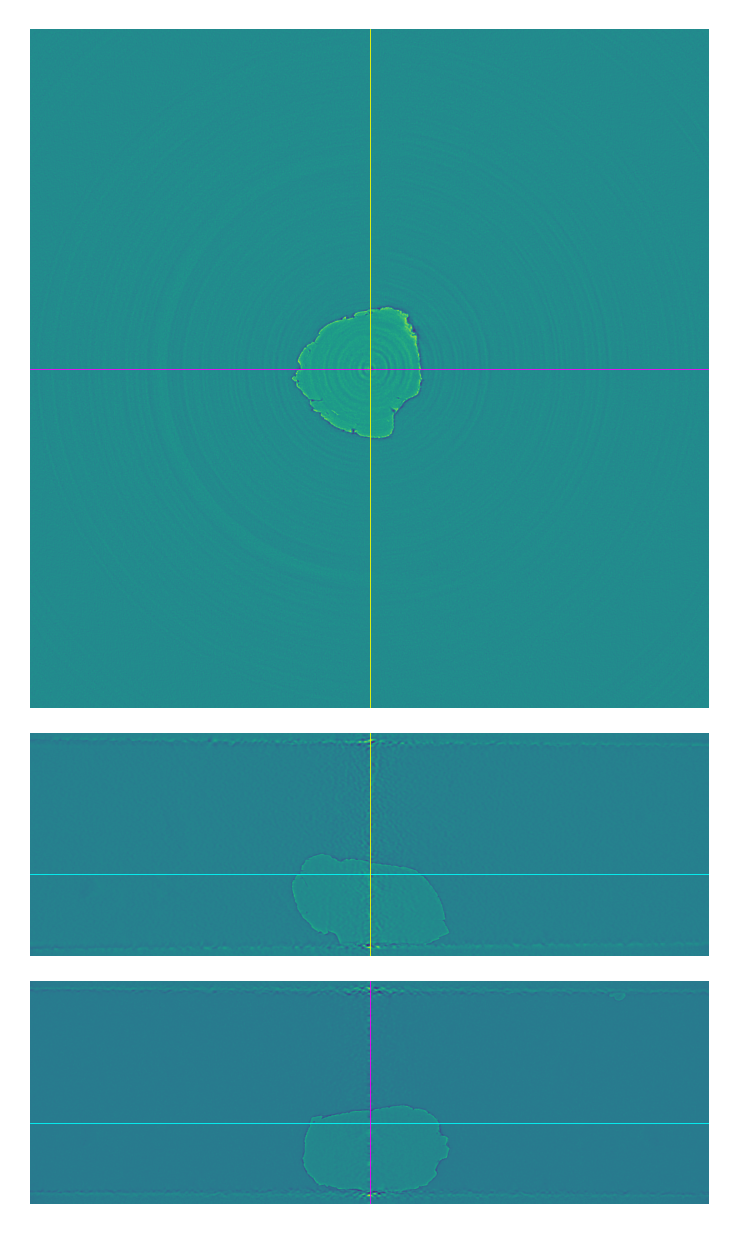

In [4]:
def plot_3d_imgs(imgs_to_plot, slice_lines=False):
    fig, axes = plt.subplots(
        3, 1, sharex=True, dpi=300, constrained_layout=True, 
        gridspec_kw={"height_ratios":[img.shape[0] for img in imgs_to_plot]}
    )
    for ax, img in zip(axes, imgs_to_plot):
        ax.imshow(img)
        ax.set_axis_off()
    if slice_lines:
        axes[0].axhline(idx_list[1], linewidth=0.2, color='magenta')
        axes[0].axvline(idx_list[2], linewidth=0.2, color='yellow')
        axes[1].axhline(idx_list[0], linewidth=0.2, color='cyan')
        axes[1].axvline(idx_list[2], linewidth=0.2, color='yellow')
        axes[2].axhline(idx_list[0], linewidth=0.2, color='cyan')
        axes[2].axvline(idx_list[1], linewidth=0.2, color='magenta')
    return fig, axes
idx_list = [400, imgs.shape[1]//2, imgs.shape[2]//2]
imgs_to_plot = [
    imgs[idx_list[0], :, :], imgs[:, idx_list[1], :], imgs[:, :, idx_list[2]]
]
fig, axes = plot_3d_imgs(imgs_to_plot, slice_lines=True)
plt.show()

In [5]:
def plot_img_cols(img_seq_list, fig_w=6):
    n_axes_h = len(img_seq_list[0])
    n_axes_w = len(img_seq_list)
    # Images may have different widths, so total img_w is the sum of the widths
    img_w = sum(
        [img_seq_list[0][i].shape[1] for i in range(len(img_seq_list[0]))]
    )
    # Images may have different heights, so total img_h is the sum of the heights
    img_h = sum(
        [img_seq_list[0][i].shape[0] for i in range(len(img_seq_list[0]))]
    )
    fig_h = fig_w * (img_h / img_w) * (n_axes_h / n_axes_w)
    fig, axes = plt.subplots(
        nrows=n_axes_h, ncols=n_axes_w, figsize=(fig_w, fig_h), sharex=True, 
        dpi=300, constrained_layout=True, 
        gridspec_kw={"height_ratios":[img.shape[0] for img in img_seq_list[0]]}
    )
    for i, img_seq in enumerate(img_seq_list):
        for ax, img in zip(axes[:, i], img_seq):
            ax.imshow(img, interpolation='nearest')
            ax.set_axis_off()
    return fig, axes

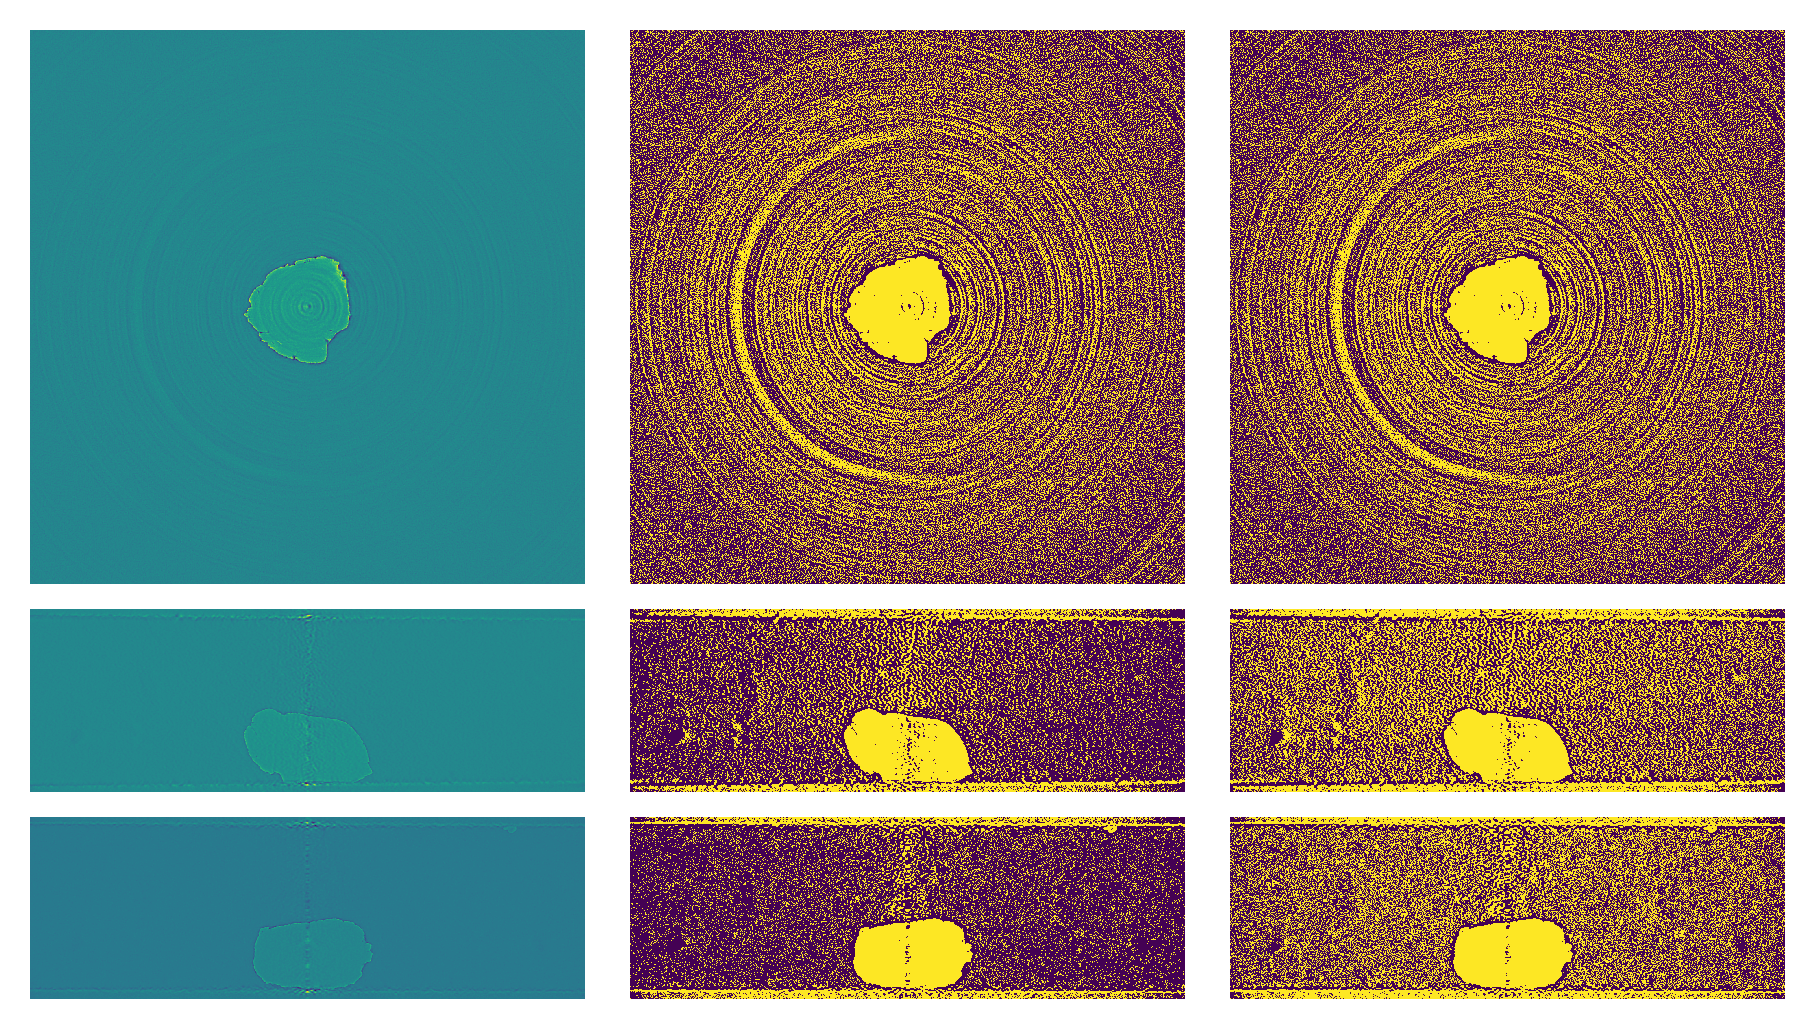

In [6]:
median_imgs = [
    skimage.filters.median(img) for img in imgs_to_plot
]
mean_thresh_imgs = [
    img > img.mean() for img in median_imgs
]
median_thresh_imgs = [
    img > np.median(img) for img in median_imgs
]
fig, axes = plot_img_cols(
    [median_imgs, mean_thresh_imgs, median_thresh_imgs]
)
plt.show()

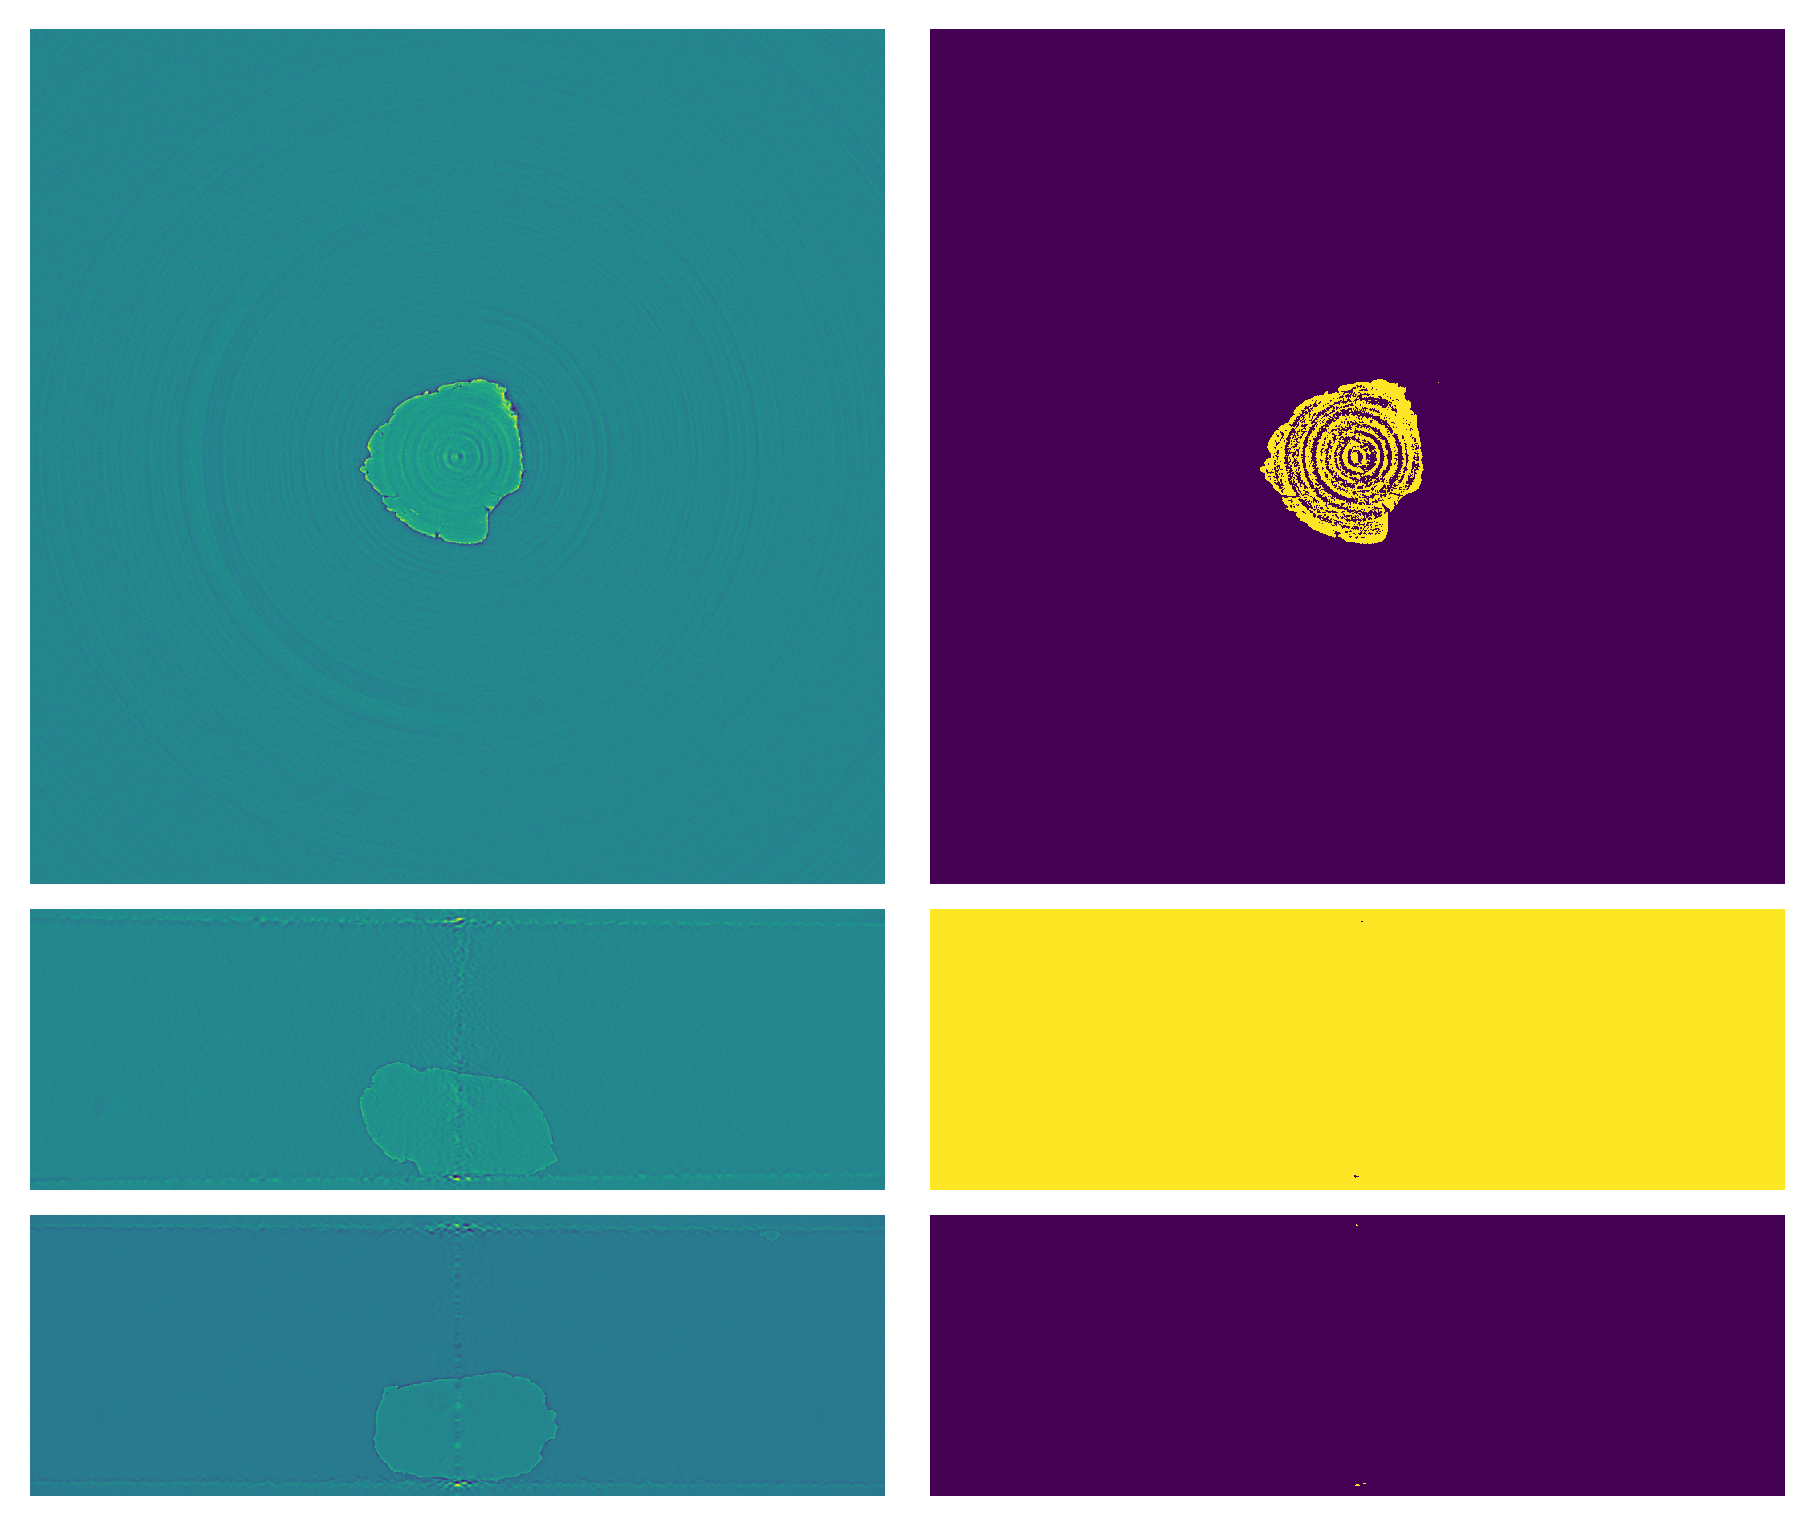

In [7]:
idx_list = [400, imgs.shape[1]//2, imgs.shape[2]//2]
imgs_to_plot = [
    imgs[idx_list[0], :, :], imgs[:, idx_list[1], :], imgs[:, :, idx_list[2]]
]
median_imgs = [
    skimage.filters.median(img) for img in imgs_to_plot
]
min_thresh_imgs = [
    img > skimage.filters.threshold_minimum(img) for img in median_imgs
]
fig, axes = plot_img_cols(
    [median_imgs, min_thresh_imgs]
)
plt.show()

In [8]:
def plot_imgs(imgs, fig_w=6, nrows=3):
    n_imgs = len(imgs)
    # Check if 3 rows can be shared, else decrement by 1 until down to 1 row  
    while n_imgs % nrows != 0:
        nrows -= 1
    ncols = n_imgs // nrows
    img_w = imgs[0].shape[1]
    img_h = imgs[0].shape[0]
    fig_h = fig_w * (img_h / img_w) * (nrows / ncols)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(fig_w, fig_h), dpi=300,
        constrained_layout=True, 
    )
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(imgs[i], interpolation='nearest')
        ax.set_axis_off()
    return fig, axes

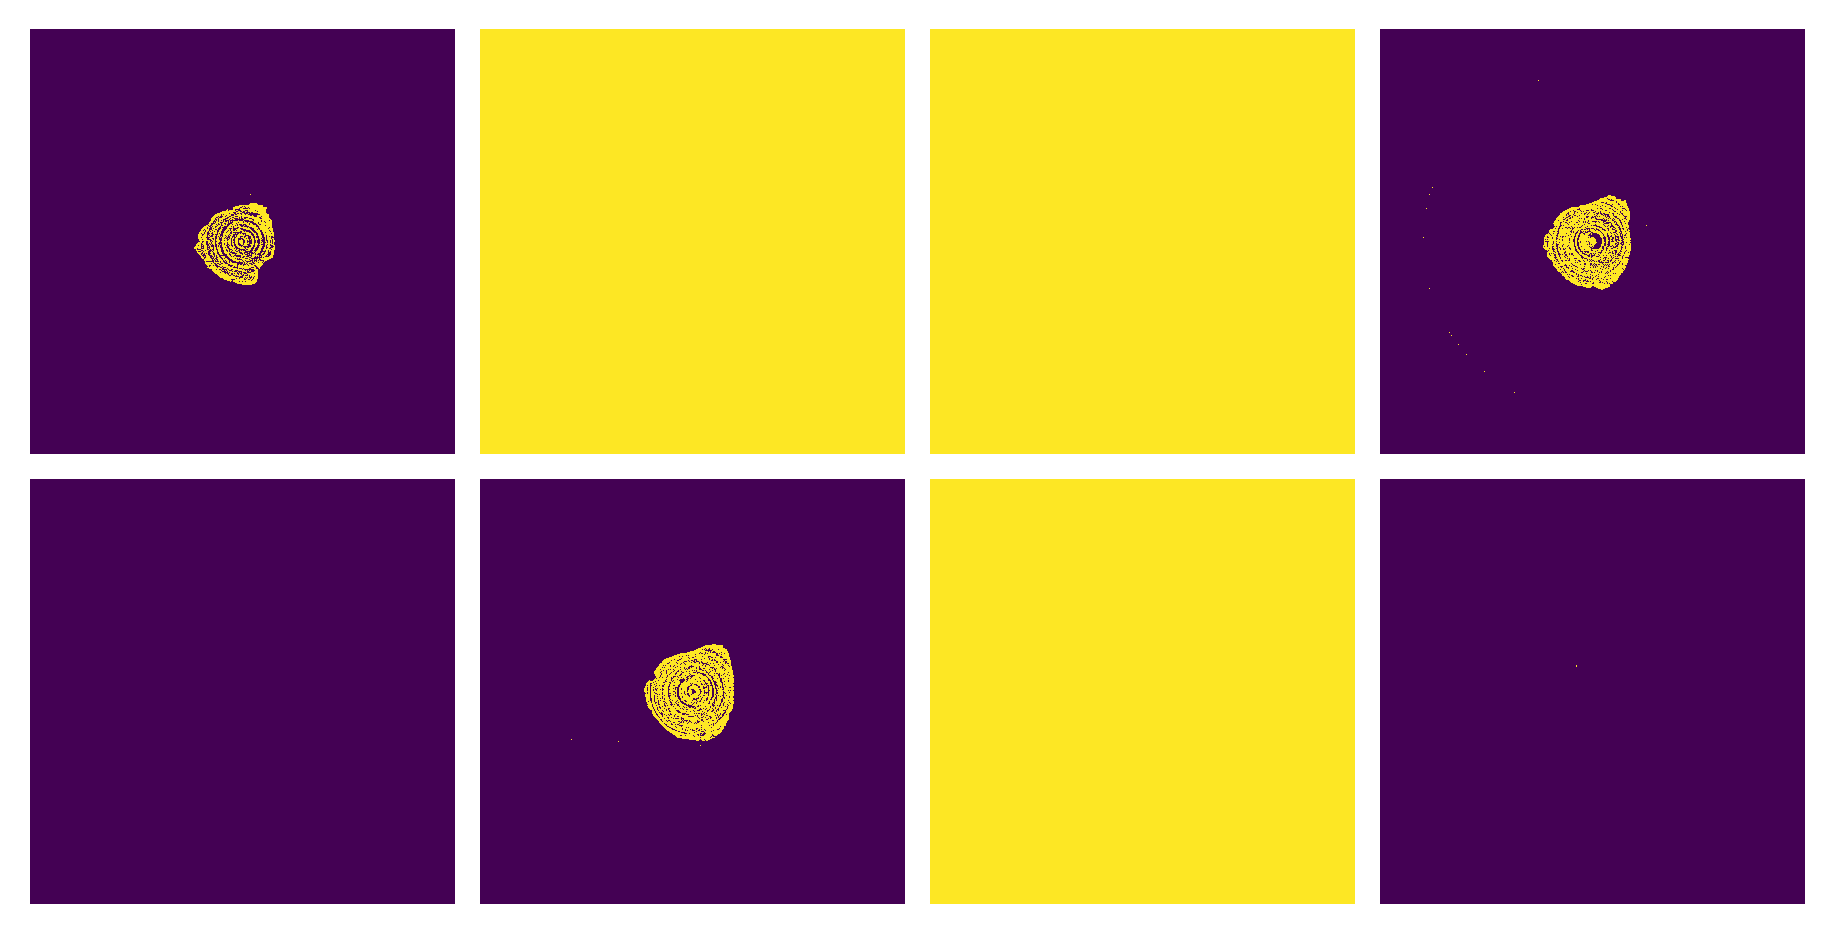

In [9]:
imgs_to_plot = [imgs[i, :, :] for i in np.arange(400, 480, 10)]
median_imgs = [
    skimage.filters.median(img) for img in imgs_to_plot
]
min_thresh_imgs = [
    img > skimage.filters.threshold_minimum(img) for img in median_imgs
]
fig, axes = plot_imgs(min_thresh_imgs)
plt.show()

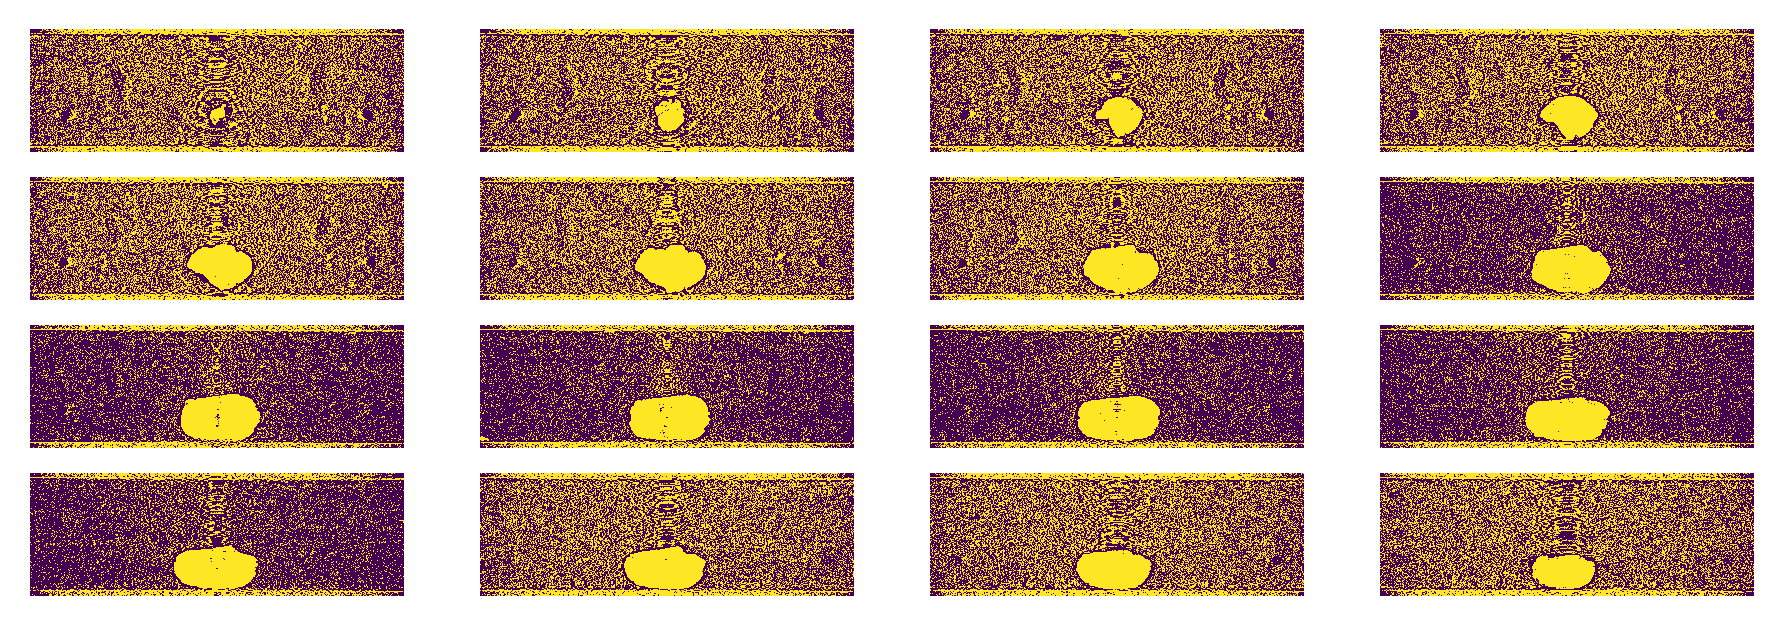

In [10]:
imgs_to_plot = [imgs[:, :, i] for i in np.arange(750, 1150, 25)]
median_imgs = [
    skimage.filters.median(img) for img in imgs_to_plot
]
min_thresh_imgs = [
    img > img.mean() for img in median_imgs
]
fig, axes = plot_imgs(min_thresh_imgs, nrows=4)
plt.show()

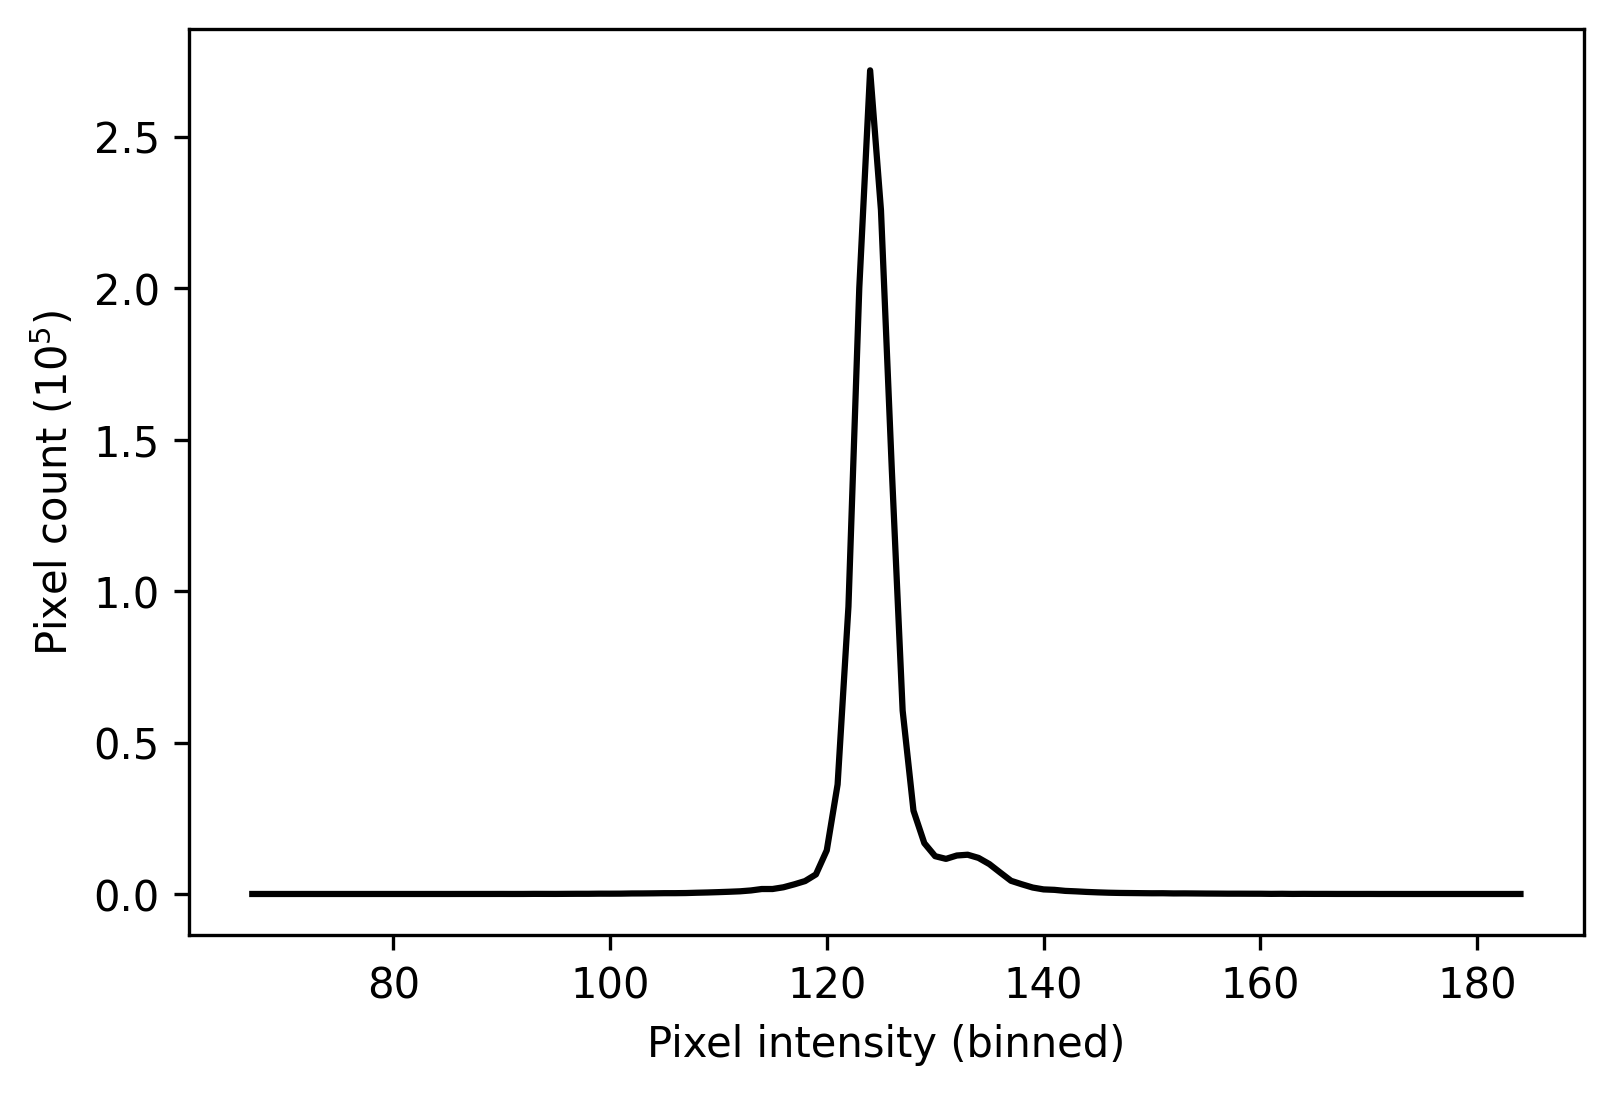

In [33]:
img = skimage.filters.median(imgs[:, :, 1100])
hist, hist_centers = skimage.exposure.histogram(img)
fig, ax = plt.subplots(dpi=300)
e_scale = 5
ax.plot(hist_centers, hist / 10**e_scale, color='black')
ax.set_xlabel('Pixel intensity (binned)')
ax.set_ylabel(f"Pixel count ($10^{e_scale}$)")
plt.show()

(2524, 1920)


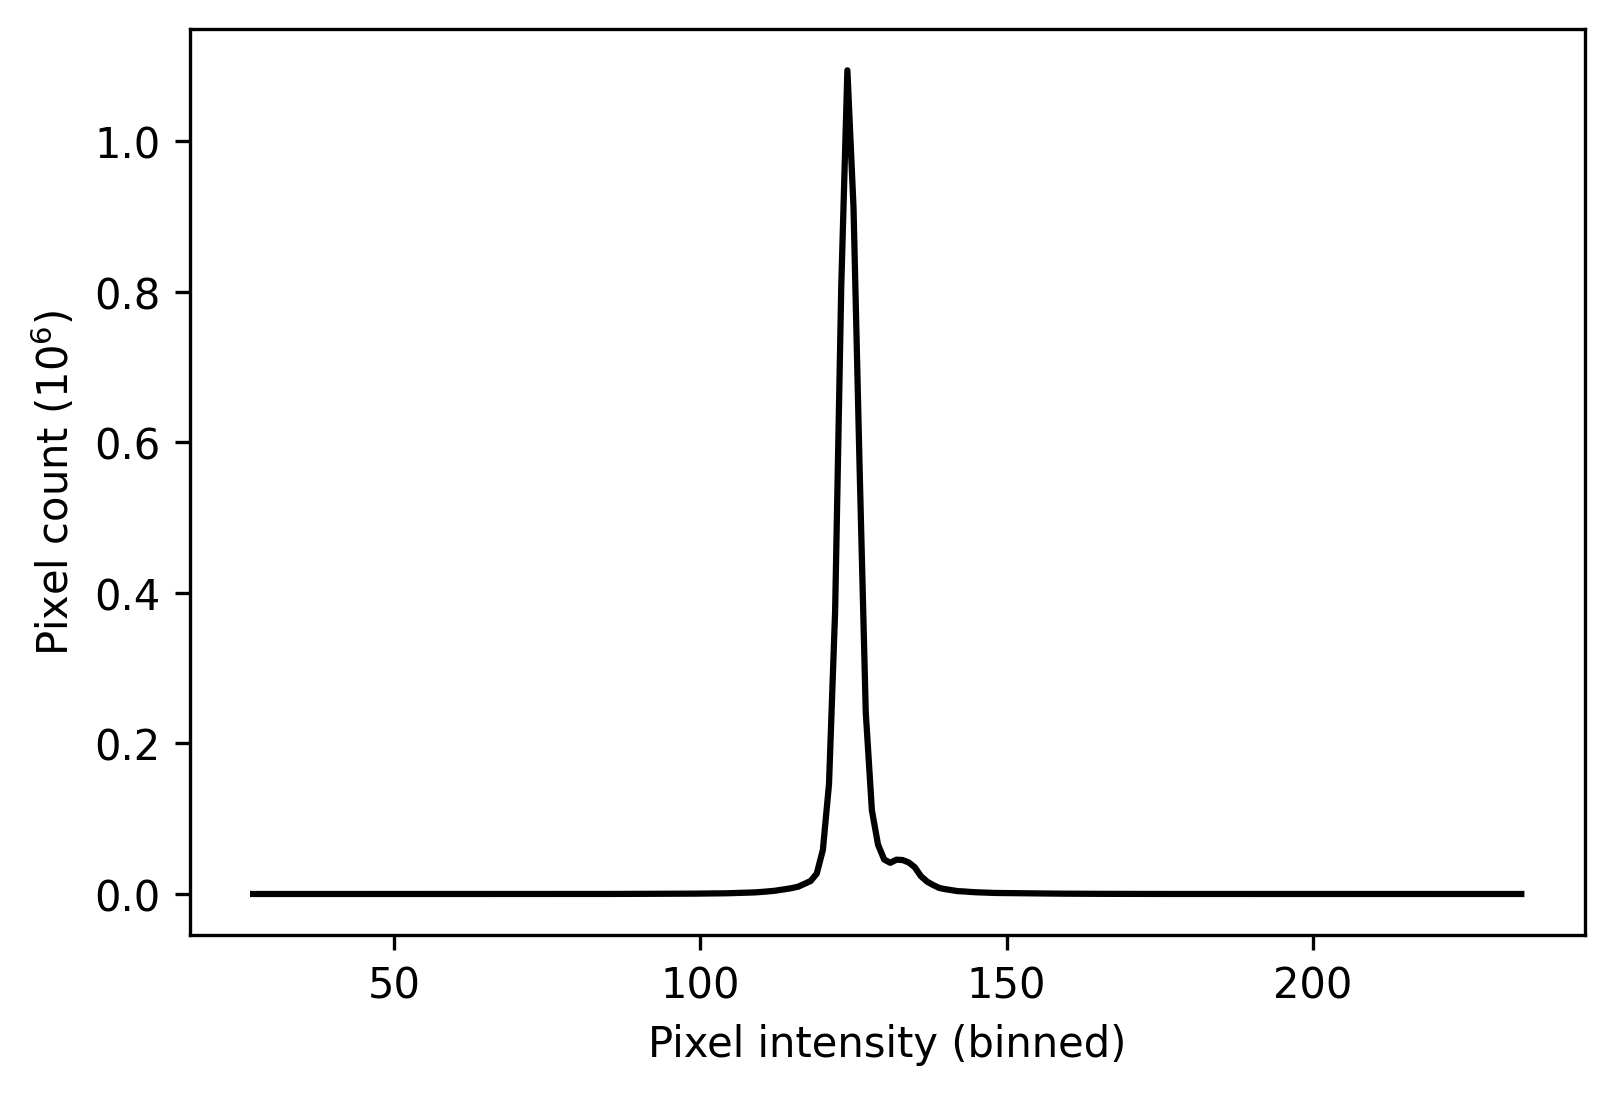

In [36]:
median_imgs = [
    skimage.filters.median(imgs[:, :, i]) for i in np.arange(750, 1150, 100)
]
median_imgs_concat = np.concatenate(tuple(img for img in median_imgs))
print(median_imgs_concat.shape)
hist, hist_centers = skimage.exposure.histogram(median_imgs_concat)
fig, ax = plt.subplots(dpi=300)
e_scale = 6
ax.plot(hist_centers, hist / 10**e_scale, color='black')
ax.set_xlabel('Pixel intensity (binned)')
ax.set_ylabel(f"Pixel count ($10^{e_scale}$)")
plt.show()

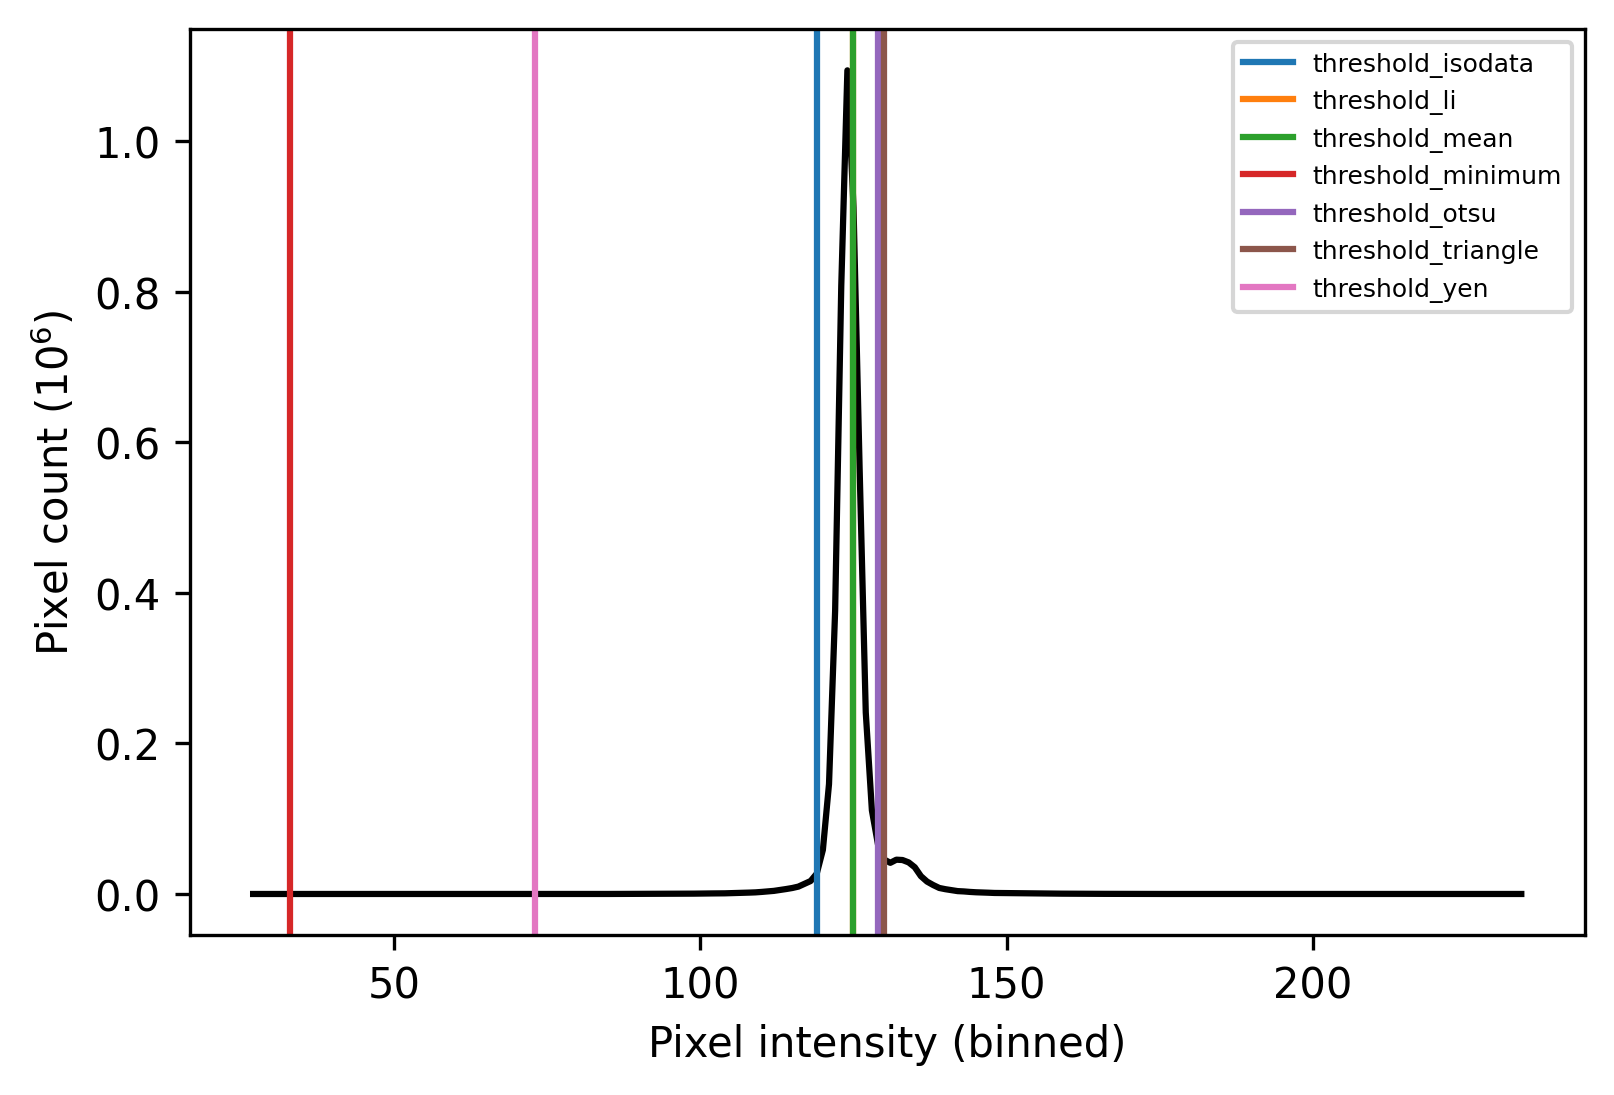

In [37]:
from skimage.filters import (
    threshold_mean, threshold_isodata, threshold_triangle,
    threshold_li, threshold_minimum, threshold_otsu, threshold_yen  
)
fig, ax = plt.subplots(dpi=300)
e_scale = 6
ax.plot(hist_centers, hist / 10**e_scale, color='black')
ax.set_xlabel('Pixel intensity (binned)')
ax.set_ylabel(f"Pixel count ($10^{e_scale}$)")
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, threshold in enumerate([
    threshold_isodata, threshold_li, threshold_mean, threshold_minimum, 
    threshold_otsu, threshold_triangle, threshold_yen
]):
    thresh = threshold(median_imgs_concat)
    ax.axvline(thresh, color=colors[i], label=threshold.__name__)
ax.legend(prop={'size': 6})
plt.show()

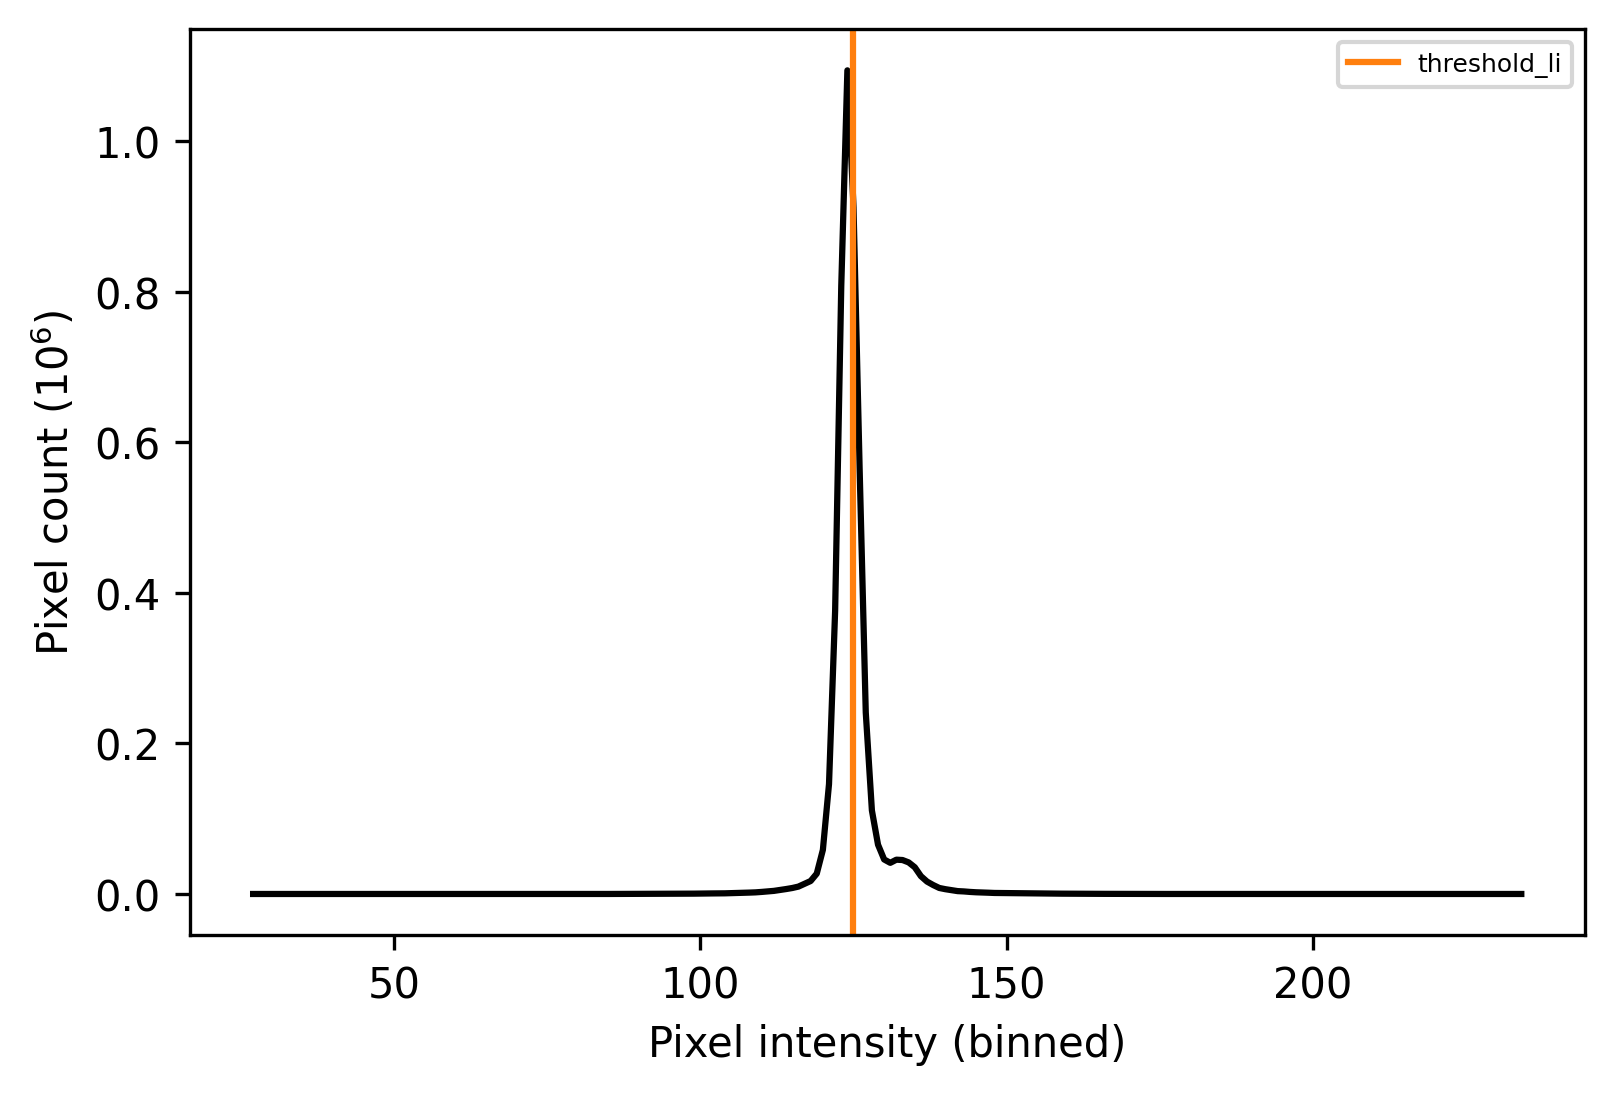

In [38]:
fig, ax = plt.subplots(dpi=300)
e_scale = 6
ax.plot(hist_centers, hist / 10**e_scale, color='black')
ax.set_xlabel('Pixel intensity (binned)')
ax.set_ylabel(f"Pixel count ($10^{e_scale}$)")
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
thresh = threshold_li(median_imgs_concat)
ax.axvline(thresh, color=colors[1], label=threshold_li.__name__)
ax.legend(prop={'size': 6})
plt.show()

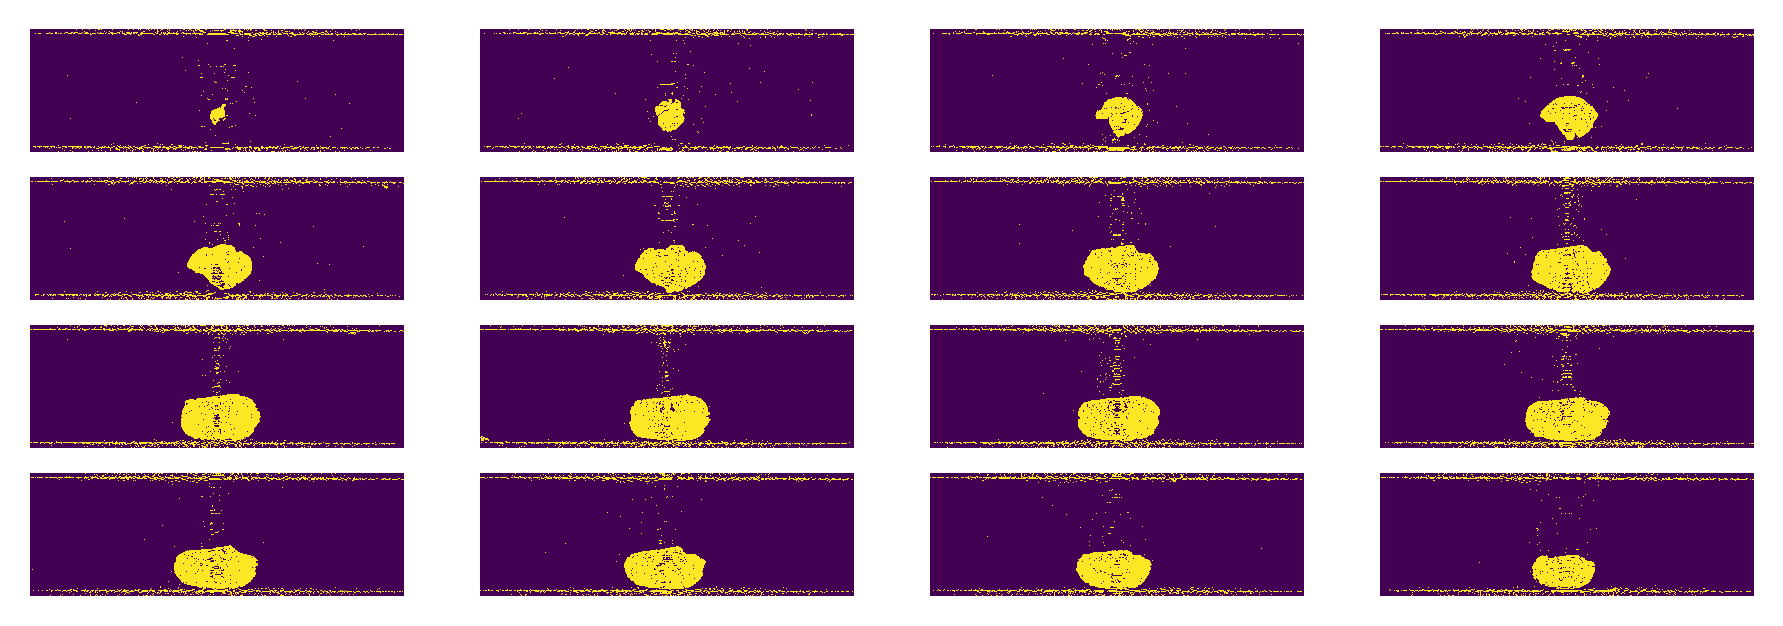

In [39]:
median_imgs = [
    skimage.filters.median(imgs[:, :, i]) for i in np.arange(750, 1150, 25)
]
median_imgs_concat = np.concatenate(tuple(img for img in median_imgs))
hist, hist_centers = skimage.exposure.histogram(median_imgs_concat)
thresh = skimage.filters.threshold_otsu(median_imgs_concat)
min_thresh_concat_imgs = [
    img > thresh for img in median_imgs
]
fig, axes = plot_imgs(min_thresh_concat_imgs, nrows=4)
plt.show()

In [40]:
print('Calculating median images...')
median_imgs = [
    skimage.filters.median(imgs[:, :, i]) for i in np.arange(700, 1200, 1)
]
n_imgs = len(median_imgs)
print(f'Concatenating {n_imgs} images...')
median_imgs_concat = np.concatenate(tuple(img for img in median_imgs))
print('Calculating threshold value...')
thresh = skimage.filters.threshold_otsu(median_imgs_concat)
print('Thresholding images...')
otsu_thresh_imgs = [
    img > thresh for img in median_imgs
]
print('Adding images to napari...')
viewer.add_image(np.stack(otsu_thresh_imgs))

Calculating median images...
Concatenating {n_imgs} images...
Calculating threshold value...
Thresholding images...
Adding images to napari...


<Image layer 'Image' at 0x209f33e9b80>

In [47]:
print(f'{imgs.shape=}')
print(f'{len(median_imgs)=}')
print(f'{median_imgs[0].shape=}')
print(f'{len(otsu_thresh_imgs)=}')
print(f'{otsu_thresh_imgs[0].shape=}')
print(f'{np.stack(otsu_thresh_imgs).shape=}')

imgs.shape=(631, 1920, 1920)
len(median_imgs)=500
median_imgs[0].shape=(631, 1920)
len(otsu_thresh_imgs)=500
otsu_thresh_imgs[0].shape=(631, 1920)
np.stack(otsu_thresh_imgs).shape=(500, 631, 1920)


In [53]:
viewer.add_image(np.stack(otsu_thresh_imgs).T, translate=[0, 0, 700])

<Image layer 'Image [3]' at 0x209c60228e0>